Notebook originally downloaded from [this blog](https://blogs.oracle.com/ai-and-datascience/post/deploying-a-machine-learning-model-with-oracle-functions).

Note that these steps assume that you are a tenancy admin whose user has privileges to manage all resources in the tenancy.

**Prerequisites:**
- Make sure that this notebook is included as part of a Dynamic Group (e.g. DSDynamicGroup) with a matching rule:\
    `ALL {resource.type = 'datasciencenotebooksession', resource.id = '<ID of this Notebook Session>'}`

- Make sure that there are policy statements that enable dynamic group to access the necessary resources. E.g.:\
    `Allow service datascience to use virtual-network-family in compartment <name of compartment with networking resources>`
    
     `Allow service datascience to manage data-science-family in compartment <name of compartment with Data Science resources>`

    `Allow service datascience to use functions-family in compartment <name of compartment with Functions resources>`
   
    `Allow dynamic-group DSDynamicGroup to use virtual-network-family in compartment <name of compartment with networking resources>`

    `Allow dynamic-group DSDynamicGroup to manage data-science-family in compartment <name of compartment with Data Science resources>`
    
    `Allow dynamic-group DSDynamicGroup to use functions-family in compartment <name of compartment with Functions resources>`

**To use this notebook, use Kernel:**
`conda env:generalmachinelearningforcpusv2_0`

How to set up kernel:
- `File` > `New Launcher`
- Click `Environment Explorer`
- Search for the Conda environment listing using the Conda environment's slug name: `generalmachinelearningforcpusv2_0` (or search for `General Machine Learning for CPUs`, and find the listing for `v2.0`)
- On the Conda environment listing, follow the `Install` instructions`General Machine Learning for CPUs`

These steps cover how to build and train a model in a notebook session of the OCI Data Science service and deploy that model with Oracle Functions. 

Before we get started, let's make sure we upgrade the client `oci` to the latest version. Some of the capabilities around logging and log search are only available in the recent versions of `oci`. In a cell of your notebook, execute: 

In [3]:
%%bash 

pip install oci --upgrade
pip install fdk
pip install pandas
pip install numpy
pip install scikit-learn
pip install cloudpickle

## Training a model in a Notebook Session and Saving it to the Model Catalog 

To get started I train a simple binary classifier using `scikit-learn` in a notebook session of the Oracle Cloud Infrastructure Data Science service. The business problem it itself and the quality of the model do not really matter in this case and the model is only used for illustrative purposes. In fact any binary classifier would do just fine. 

I used the `sklearn` `make_classification()` function to create a balanced synthetic binary classification dataset and I am going to use it to train a random forest classifier. The model takes in eight numerical features labelled `feat1`,...,`feat8`. 

You can do the same by launching a notebook session in Oracle Cloud Infrastructure Data Science service and execute the following cell in your notebook. I am using [resource principals](https://blogs.oracle.com/datascience/resource-principals-data-science-service) to authenticate to the model catalog, object storage, and Oracle Functions. I recommend going over the `getting-started.ipynb` notebook yourself to get your session set up with resource principals. 

In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import ads 

# Using resource principal to authenticate when using the model catalog: 
ads.set_auth(auth='resource_principal') 

# Here we create a simple (balanced) binary classfication dataset with 8 features, 
# and a sample of 10K rows. 
X, y = make_classification(n_samples=10000, n_features=8, n_informative=4,
                           random_state=0, shuffle=True)

# convert to a pandas dataframe for easy manipulations: 
train = pd.DataFrame(X, columns=['feat1', 'feat2', 'feat3', 'feat4', 
                                 'feat5', 'feat6', 'feat7', 'feat8'])
target = pd.Series(y)

In [5]:
target.value_counts()

1    5002
0    4998
dtype: int64

From the `value_counts()` call you can see that the dataset is balanced which is what I want. 

Next step is to train a simple binary classifier. In this case, I use a `RandomForestClassifier` also available in `scikit-learn`: 

In [6]:
# training the random forest classifier from scikit-learn: 
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, target)

RandomForestClassifier(max_depth=2, random_state=0)

In [7]:
predictions = clf.predict(X)
diff = np.abs(predictions - y)
print(f"accuracy (train):{1.0 - sum(diff) / len(predictions)}")

accuracy (train):0.7575000000000001


I get an accuracy on the training set of about 0.75 which works for our purposes.

I now have a working binary classifier. Next step will be to save this model to the [model catalog](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/manage-models.htm). 

### Saving the Model in the Model Catalog 

To save the model in the catalog we are going to use the `ads` library and its `prepare_generic_model()` function. That is probably the easiest way to save a model to the catalog. The first step is to create a temporary local directory where we are going to store the model artifact files: 

In [9]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os

#Replace with your own path: 
path_to_rf_artifact = f"ML_Model_Artifact"
if not os.path.exists(path_to_rf_artifact):
    os.mkdir(path_to_rf_artifact)

I use ADS `prepare_generic_model()` to create all the necessary templatized files that are part of the model artifact. You still need to modify each one of the files in the artifact to fit your particular use case. In the next few cells I will go each one of the files I modified and create. Note that all the files in the target artifact directory will be compressed and shipped to the model catalog as your model artifact. 

In [10]:
artifact = prepare_generic_model(path_to_rf_artifact, force_overwrite=True, data_science_env=True)

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


You will notice that in the latest release of the notebook session environment ADS also generates all the Oracle Functions artifact files (`func.py`, `func.yaml`, `requirements.txt`) by default. That is quite handy because I will later deploy my model as an Oracle Function. 

I first need to serialize my random forest classifier and save it to disk. I use `joblib` to save my model to disk which is the preferred way for [scikit-learn models](https://scikit-learn.org/stable/modules/model_persistence.html). 

In [11]:
from joblib import dump

dump(clf, os.path.join(path_to_rf_artifact, "rf.joblib"))

['ML_Model_Artifact/rf.joblib']

Now that we have a serialized model object in our artifact directory, the next step is to modify the file `func.py` which contains the definition of the Oracle Functions handler (`handler()`) function. The handler function is the function that is being called by Oracle Functions. 

#### Adding Loggers to handler() 

In the cell below I wrote a new version of `func.py`. Executing this cell will overwrite the template ADS provides as part of the model artifact. 

You should note a couple of differences with respect to the template. First, I import the Python `logging` library and define a couple of loggers: `model-prediction` and `model-input-features`. I am using these two loggers to capture the model predictions and the model input features for each call made to the Function. That is what I need to monitor how my predictions and features distributions are changing over time. Those log entries are captured and stored in the [Logging service](https://docs.cloud.oracle.com/en-us/iaas/Content/Logging/Concepts/loggingoverview.htm#loggingoverview). Second, I added some additional data transformations in `handler()`. You could have achieved a similar outcome by adding those transformations to the body of `predict()` in `score.py`. 

In [12]:
%%writefile {path_to_rf_artifact}/func.py

import io
import json

from fdk import response
import sys
sys.path.append('/function')
import score
import pandas as pd
model = score.load_model()

# Importing and configuring logging: 
import logging
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)

# configuring logging: 
# For model predictions: 
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
# For the input feature vector: 
logger_input = logging.getLogger('model-input-features')
logger_input.setLevel(logging.INFO)

def handler(ctx, data: io.BytesIO=None):
    try:
        input = json.loads(data.getvalue())['input']
        logger_input.info(input)
        input2 = json.loads(input)
        input_df = pd.DataFrame.from_dict(input2)
        prediction = score.predict(input_df, model)
        logger_pred.info(prediction)
    except (Exception, ValueError) as ex:
        logger_pred.info("prediction fail {}".format(str(ex)))

    return response.Response(
        ctx, response_data=json.dumps("predictions: {}".format(prediction)),
        headers={"Content-Type": "application/json"}
    )

Overwriting ML_Model_Artifact/func.py


Next I modify the `requirements.txt` file. ADS generates a template for `requirements.txt` that provides a best guess at the dependencies necessary to build the Oracle Function and run the model. In this case, I modified the template and added dependencies on `scikit-learn` version 0.21.3: 

In [13]:
%%writefile {path_to_rf_artifact}/requirements.txt

cloudpickle
pandas
numpy
fdk
scikit-learn

Overwriting ML_Model_Artifact/requirements.txt


I am done with the Oracle Functions part. The last thing I need to do is to modify the inference script `score.py` which loads the model to memory and call the `predict()` method of the model object. 

By default, ADS generates this file assuming that you are using `cloudpickle` to read the model serialized object. In our case, we are using `joblib`. I modified `score.py` to make use of `joblib`. I left the definition of `predict()` intact. 

In [14]:
%%writefile {path_to_rf_artifact}/score.py

import json
import os
from joblib import load

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "rf.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    # X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    return { 'prediction': model.predict(data).tolist() }

Overwriting ML_Model_Artifact/score.py


### Testing the Model Artifact before Saving to the Model Catalog 

Always test your model artifact in your notebook session before saving it to the catalog, especially if your Oracle Function depends on it.

I first modify my Python path and insert the path where the `score.py` module is located. I then import `score` and  call the `predict()` function defined in `score.py`. I load the train dataset and compare the predictions from `predict()` to the `predictions` array I created right after training model. If `load_model()` and `predict()` functions are doing the right thing I should retrieve the same `predictions` array. 

In [15]:
# add the path of score.py: 
import sys 
sys.path.insert(0, path_to_rf_artifact)

from score import load_model, predict

# Load the model to memory 
_ = load_model()
# make predictions on the training dataset: 
predictions_test = predict(train, _)

# comparing the predictions from predict() to the predictions array I created above. 
print(f"The two arrays are equal: {np.array_equal(predictions_test['prediction'], predictions)}")

The two arrays are equal: True


Indeed the two arrays are identical. 

The next step is to test the Function's handler defined in `func.py`. What I did in the cell below is to use the [fnproject Python SDK](https://fnproject.io/tutorials/python/intro/) (aka `fdk`) to import the `context` object. The `context` object is a required argument to the`handler()` function. It contains attributes such as the application ID, the function ID, the call ID, and the content type of the payload data. 

In this case, I do not know what the application ID, the function ID or the call ID are for my deployed Function. These attributes are known after the function has been deployed to Oracle Functions. For now, I just filled the required parameters with "na" values which is fine for testing purposes. 

I also took the first five rows of my training dataframe (`train[:5]`), transform them to JSON, and passed them to the handler. This is a general example showing how a Function can score multiple examples at once. 

In [16]:
import func
import json 
import logging
from func import handler
from fdk import context
from io import BytesIO

# Example context: 
# app_id, fn_id, call_id, and content_type: 
ctx = context.InvokeContext("na", "na", "na", content_type='application/json')
# Input feature values: 
input_data = {'input':train[:5].to_json()}
json_input = json.dumps(input_data).encode("utf-8")
# calling the Function's handler with my payload: 
resp = handler(ctx, BytesIO(json_input))

# remove most logs printed to screen except critical ones
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

INFO:model-input-features:{"feat1":{"0":3.8815796596,"1":1.678643493,"2":-4.7669240308,"3":-2.20278505,"4":0.4652794655},"feat2":{"0":-0.3402662912,"1":-0.4280555381,"2":2.6312464068,"3":1.6470636369,"4":0.0273087519},"feat3":{"0":-0.0374828975,"1":1.6649737554,"2":0.1725793304,"3":0.0372956515,"4":-0.9019535715},"feat4":{"0":-1.5182419529,"1":-2.9108088905,"2":3.67248617,"3":0.3577666041,"4":-1.0678704915},"feat5":{"0":1.025990203,"1":1.9400375771,"2":0.6073832548,"3":-1.6101278161,"4":1.0300792246},"feat6":{"0":-0.9173949898,"1":-0.0379263989,"2":1.3415808721,"3":-0.4342151507,"4":-0.4973747845},"feat7":{"0":2.7693137607,"1":-1.3044737808,"2":-2.9138678313,"3":-0.8296897744,"4":-0.3614324537},"feat8":{"0":1.3094495267,"1":-1.337363739,"2":-3.9009997936,"3":-0.1496719827,"4":-1.4730656516}}


2021-11-24 19:06:02,808 - model-input-features - INFO - {"feat1":{"0":3.8815796596,"1":1.678643493,"2":-4.7669240308,"3":-2.20278505,"4":0.4652794655},"feat2":{"0":-0.3402662912,"1":-0.4280555381,"2":2.6312464068,"3":1.6470636369,"4":0.0273087519},"feat3":{"0":-0.0374828975,"1":1.6649737554,"2":0.1725793304,"3":0.0372956515,"4":-0.9019535715},"feat4":{"0":-1.5182419529,"1":-2.9108088905,"2":3.67248617,"3":0.3577666041,"4":-1.0678704915},"feat5":{"0":1.025990203,"1":1.9400375771,"2":0.6073832548,"3":-1.6101278161,"4":1.0300792246},"feat6":{"0":-0.9173949898,"1":-0.0379263989,"2":1.3415808721,"3":-0.4342151507,"4":-0.4973747845},"feat7":{"0":2.7693137607,"1":-1.3044737808,"2":-2.9138678313,"3":-0.8296897744,"4":-0.3614324537},"feat8":{"0":1.3094495267,"1":-1.337363739,"2":-3.9009997936,"3":-0.1496719827,"4":-1.4730656516}}


INFO:model-prediction:{'prediction': [1, 0, 0, 0, 0]}


2021-11-24 19:06:02,833 - model-prediction - INFO - {'prediction': [1, 0, 0, 0, 0]}


You should be able to see on the screen the outputs of the two loggers you defined in `func.py`: a dictionary containing the values of the input features for all five row examples as well as a prediction array corresponding to the five predictions (0/1) made by my binary classifer. 

To help with testing the Function in production, I decided to capture a sample payload of the training dataframe. I save that sample payload file as part of the model artifact file though this is not strictly necessary. You can do the same for your own sample payload file:  

In [17]:
# Capturing a sample payload file for testing the Function in production: 

with open(os.path.join(path_to_rf_artifact, "sample-payload.json"),'w') as f:
    json.dump(input_data,f)

I have tested the files I need to deploy my model as an Oracle Function. Now I am ready to save my model artifact to the model catalog. 

ADS makes it easy for me. I can simply call the `save()` method of the model artifact I previously created. If you execute that command you should be able to see a dataframe object with metadata about your model confirming that the save operation was successful. 

You can go back to the project page in the Oracle Cloud Infrastructure Console. Under "Models" you should see a new entry corresponding to the model you just saved. 

In [18]:
# Saving the model artifact to the model catalog. 

artifact.save(display_name='simple-sklearn-model', 
              description='An initial test to monitor my model in production')

,
id,ocid1.datasciencemodel.oc1.iad.amaaaaaawe6j4fqanmcyoljd364pl4pseyv6heabfmv3qmorapupev4lebia
compartment_id,ocid1.compartment.oc1..aaaaaaaavssesqshjrt3m3fcwludxbbv3s3ff4773htbtu5iu77ows5zq7ma
project_id,ocid1.datascienceproject.oc1.iad.amaaaaaawe6j4fqa47anclib4lxfvslrduzyzmyrtl4cbxneigfrgu4avhta
display_name,simple-sklearn-model
description,An initial test to monitor my model in production
lifecycle_state,ACTIVE
time_created,2021-11-24 19:07:45.457000+00:00
created_by,ocid1.datasciencenotebooksession.oc1.iad.amaaaaaawe6j4fqahp3avky5ikgukydn7g2ovjrodcksuhjnf5mkz3dcxqlq
freeform_tags,{}
defined_tags,"{'Oracle-Tags': {'CreatedBy': 'ocid1.datasciencenotebooksession.oc1.iad.amaaaaaawe6j4fqahp3avky5ikgukydn7g2ovjrodcksuhjnf5mkz3dcxqlq', 'CreatedOn': '2021-11-24T19:07:45.323Z'}}"


Two options for deploying a model artifact are:

- As an **Oracle Function** (serverless, cold machine)
- As a **Model Deployment** (reserved but can be deactivated when not in use, hot machine)

This notebook covers the steps for deploying a model artifact as an Oracle Function, though the model can also be deployed as a Model Deployment at this point. Follow the instructions in [this documentation](https://docs.oracle.com/en-us/iaas/data-science/using/model_dep_create.htm) to deploy the model as a Model Deployment.

# Deploying the model as an Oracle Function through Oracle Cloud Infrastructure Cloud Shell

I completed the model training steps and I was able to save an artifact to the model catalog. The next step is to take the model artifact I saved, build an Oracle Function Docker image, push that image to the Oracle Registry and deploy that image as an Oracle Function. 

Fortunately we can accomplish all these steps using the [Cloud Shell service](https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/cloudshellintro.htm) available in the Oracle Cloud Infrastructure console. In principle you can do all that work from your laptop but cloud shell is very easy to use and comes pre-configured with your own OCI credentials, Docker, and the Function CLI (`fn`). 

To access Cloud Shell, simply go in the console home page and click on the cloud shell icon in the top most bar. 

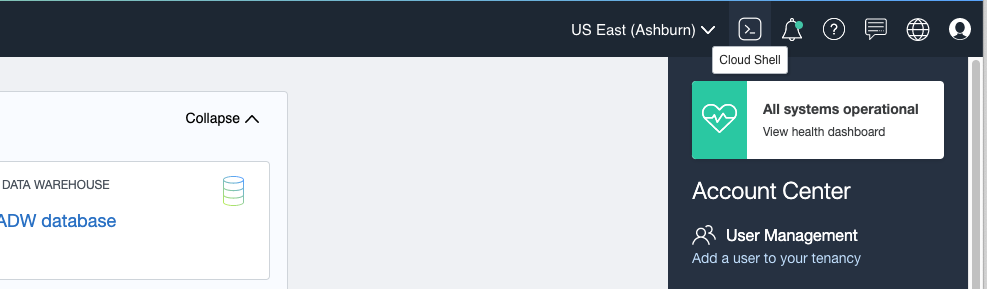

Once I have a cloud shell window running the first step is to download the model artifact I just created. This can be done by downloading and unzipping the artifact file using these two shell commands. Replace with your model OCID value. You can find the model OCID value in the model details page shown below. 

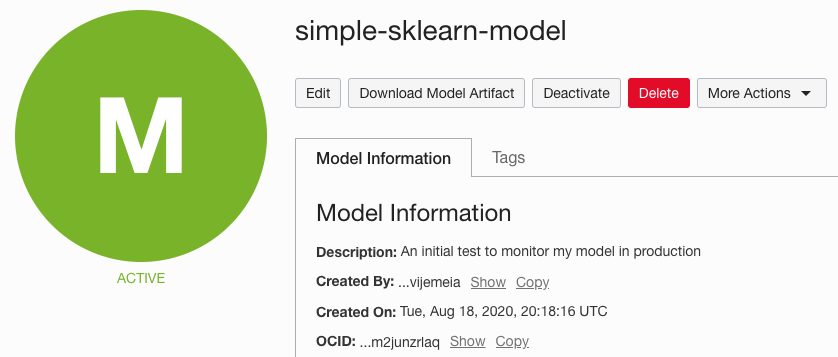

```
% oci data-science model get-artifact-content --model-id <your-model-ocid> --file test.zip
% unzip test.zip 
```

Next step is to create an Oracle Function application that will host your machine learning model Function. Simply go to the Oracle Cloud Infrastructure Console and go under **"Developer services > Functions"**. Select **"Create Application"**. 

Create an `Application` and name it (e.g. App Random Forest Binary Classifier), and choose subnets that have a NAT gateway and Service Gateway set up with route rules that enable communication between the gateways.

After creating your application, make sure that your application has logs enabled. Go to **Logs** under the left menu **Resources**. You will select a [log group, log name, and retention period](https://docs.cloud.oracle.com/en-us/iaas/Content/Logging/Task/managinglogs.htm) for your logs.  

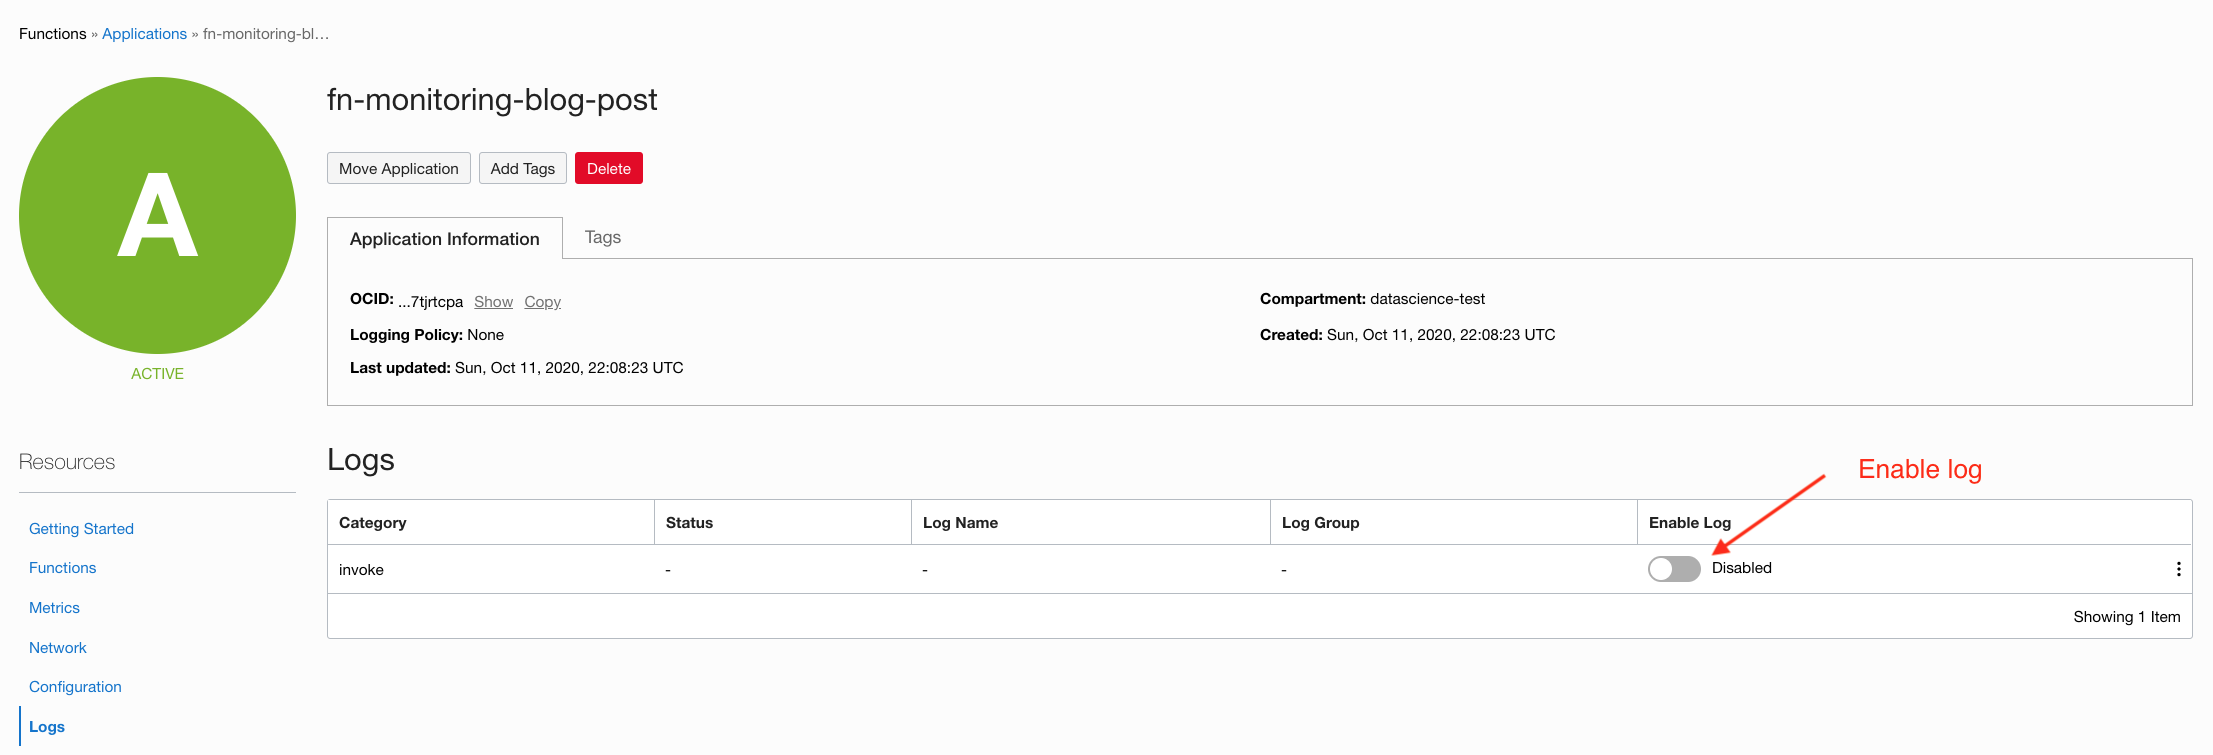

Once you have created an application, I highly recommend that you go through **Getting Started** in the left **Resources** menu of your application. The Getting Started guide will walk you through the necessary steps to configure the `fn` CLI in your cloud shell environment as well as `docker`.

**Before you deploy your function** in the `Deploy your function` step, make sure the following is set up to ensure a successful deployment:

1. The file `~/.fn/contexts/<region identifier>.yaml`, where `<region identidier>` is the region where your `Application exists`, has the following content:

```
api-url: https://functions.<region identifier of your context>.oci.oraclecloud.com
oracle.compartment-id: <compartment where the Application exists>
provider: oracle-cs
registry: <region key of your context>.ocir.io/orasenatdpltintegration03/<a prefix of your choosing>
```
2. At least one of the following is set up:

    - A `repository` in the `OCI Container Registry` is created with the following naming scheme: `/<the prefix of your choosing from Step 1.>/<the value to the 'name' key from func.yaml>`
    
    - `is-repository-created-on-first-push` is set to `true` in the compartment where you will deploy a `OCI Container Registry` `repository`. You can check with this OCI-CLI command from the Cloud Shell:
    
    `oci artifacts container configuration get --compartment-id <COMPARTMENT_ID where the Application exists>`


After these steps are finished, you can deploy your Function, passing the name of your Application as the value for the `--app` parameter (e.g. App Random Forest Binary Classifier).

```
% fn --verbose deploy --app 'App Random Forest Binary Classifier'
```

You should see a successful Docker image build in cloud shell. The image will be stored in the Registry and your new Function can be found in the console in your application. 

# Invoking the Deployed Function

I followed the steps above and my Oracle Function has been successfully deployed. Now I need to test it. An easy way to do test my Function is to submit a few requests by using the OCI Python SDK directly in my notebook. If you prefer to use Cloud Shell, you can also [invoke your model](https://fnproject.io/tutorials/python/intro/#InvokeyourDeployedFunction) directly with the `fn` CLI tool. 

I first need to import some of the libraries I will need, most notably `oci` and the `functions` client. 

In [30]:
import matplotlib.pyplot as plt
import datetime
import gzip 

import oci 
from oci import pagination
import oci.functions as functions
from oci.functions import FunctionsInvokeClient

I am using resource principals in my notebook session to authenticate against Oracle Functions. I will instantiate a `FunctionsManagementClient` object using the resource principals signer object. This allows my notebook session to call Functions without using my personal config and key files. The `FunctionsManagementClient` object allows me to list all applications and functions in my compartment. 

In [31]:
# Lets first get the resource principals signer object: 
rps = oci.auth.signers.get_resource_principals_signer()

Fill in the compartment OCID of your application as well as your application and function names: 

In [32]:
# Your application compartment OCID: 
compartment_id = f"COMPARTMENT_ID_WHERE_APPLICATION_FOR_FUNCTIONS_WAS_CREATED"
# Your application name: 
app_name = f"App Random Forest Binary Classifier"
# Your Function name: (you can find this in func.yaml of your Function code as the value assigned to the 'name' key)
fn_name = f"model_api"

In [37]:
# you can find the OCID of the Function the page for your Function in the OCI Console: Navigate to the Application, then click the listing for your Function
function_id='FUNCTION_ID'
# you can find the invoke endpoint from an OCI-CLI call made from cloud shell, or any environment with OCI-CLI set up: oci --region <region identifier where Function exists> fn function get --function-id <function ocid>
# and then using the value from 'invoke-endpoint'
function_invoke_endpoint='INVOKE_ENDPOINT'

In [35]:
invoke_client = FunctionsInvokeClient({}, signer=rps, service_endpoint=function_invoke_endpoint)

The client object I instantiated (`invoke_client`) has an `invoke_function()` method that allows me to submit requests to my Function. It takes the Function OCID as the required parameter. 

I also cut my training dataframe into blocks of five row and passed those as my JSON payload to my Function endpoint. You can execute this cell a few times to simulate a few calls made to your Function. You can change the number of rows you pass to the model in each call. It does not really matter for this exercise. Remember that the first time you call your Function it could take significantly more time to get a response back (>30 sec). That's the cold start problem. 

For each call you made to your Functions, the output of the loggers you created in `func.py` will be collected and stored in log files on object storage. In the next section I will pull the logs, extract the relevant entries, perform a simple monitoring analysis of my model predictions. 

In [36]:
%%time 

# calling my model 10 times. Each time I pass five rows from my training datasets that I converted to a JSON payload (content-type: application/json) 
for x in range(10): 
    resp = invoke_client.invoke_function(function_id, 
                                         invoke_function_body=json.dumps({'input':train[5*x:5*(x+1)].to_json()}))
    print(resp.data.text)

"predictions: {'prediction': [1, 0, 0, 0, 0]}"
"predictions: {'prediction': [1, 0, 1, 1, 1]}"
"predictions: {'prediction': [1, 0, 0, 0, 0]}"
"predictions: {'prediction': [0, 0, 0, 0, 0]}"
"predictions: {'prediction': [1, 1, 1, 0, 0]}"
"predictions: {'prediction': [0, 1, 1, 0, 0]}"
"predictions: {'prediction': [0, 0, 0, 1, 0]}"
"predictions: {'prediction': [0, 0, 0, 0, 0]}"
"predictions: {'prediction': [0, 0, 1, 0, 0]}"
"predictions: {'prediction': [0, 0, 1, 1, 1]}"
CPU times: user 774 ms, sys: 167 ms, total: 941 ms
Wall time: 29.4 s


Congratulations! You have made it to the end! You can use the logs generated by your Function to monitor the performance of you model. 